In [35]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys # error msg, add the modules
sys.path.append('../pycode')

import json
import yaml
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

import scipy
print('scipy version : {}'.format(scipy.__version__))

#
# plot in scipy, and dendrogram
#
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage

#
# plotly
#
import plotly
plotly.tools.set_credentials_file(username='sushi830', api_key='hnYVQLwVdxWNGRVAo3Yy')
print('ploty version : {}'.format(plotly.__version__))
import plotly.plotly as py
import plotly.figure_factory as ff



# read metrics in csv to dataframe
from magus import read_trace, adjust_metric

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scipy version : 0.19.1
ploty version : 2.0.15


### dendrogram

In [36]:
def compute_cophenet(array, pdist_metric, lk_method):
    if lk_method is 'single' and pdist_metric in ['seuclidean', 'mahalanobis', 'wminkowski']:
        return None
    elif lk_method is 'complete' and pdist_metric in ['seuclidean', 'mahalanobis', 'wminkowski']:
        return None
    elif lk_method is 'average' and pdist_metric in ['seuclidean', 'mahalanobis', 'wminkowski']:
        return None
    elif lk_method is 'weighted' and pdist_metric in ['seuclidean', 'mahalanobis', 'wminkowski']:
        return None
    elif lk_method is 'centroid' and pdist_metric in ['seuclidean', 'mahalanobis', 'wminkowski']:
        return None
    elif lk_method is 'median' and pdist_metric in ['seuclidean', 'mahalanobis', 'wminkowski']:
        return None
    elif lk_method is 'ward' and pdist_metric in ['seuclidean', 'mahalanobis', 'wminkowski']:
        return None
    else:
        pd = pdist(array, metric=pdist_metric)
        Z = hierarchy.linkage(pd, method=lk_method)
        c, coph_dists = cophenet(Z, pd)
        return c

def find_best_method_metric_combination(df_app_array):
#     lk_metrics = ['euclidean',
#              'minkowski',
#              'cityblock',
#              'seuclidean',
#              'sqeuclidean',
#              'cosine',
#              'correlation',
#              'hamming',
#              'jaccard',
#              'chebyshev',
#              'canberra',
#              'braycurtis',
#              'mahalanobis',
#              'yule',
#              'matching',
#              'dice',
#              'kulsinski',
#              'rogerstanimoto',
#              'russellrao',
#              'sokalmichener',
#              'sokalsneath',
#              'wminkowski']


    lk_metrics = ['euclidean', 'cosine']

    methods= ['single', 
          'complete',
          'average', 
          'weighted', 
          'centroid',
          'median',
          'ward']
    
    val_method_metric_dd = {}
    for current_method in methods:
        metric_c_dd = {}
        for idx, current_metric in enumerate(lk_metrics):
            c = compute_cophenet(df_app_array, current_metric, current_method)
            if not c is None:
                metric_c_dd[current_metric] = c
        tuple_v_key = max(zip(metric_c_dd.values(), metric_c_dd.keys()))
        val_method_metric_dd[tuple_v_key[0]] = [current_method, tuple_v_key[1]] # c as the key, [method,metric] as value
    
    return max(zip(val_method_metric_dd.keys(), val_method_metric_dd.values()))

# load feature scaling factors for all profiling metrics

In [37]:
with open('../01_feature_selection/metrics_scale.json', 'r') as metricsFile:
     metrics_scale_dd = yaml.safe_load(metricsFile)

In [38]:
metrics_scale_dd

{'achieved_occupancy': [0.0156, 0.9946659999999999],
 'atomic_transactions': [0.0, 83039.0],
 'atomic_transactions_per_request': [0.0, 5.349603],
 'branch_efficiency': [0.7297148, 1.0],
 'cf_executed': [1.0, 220609193.0],
 'cf_fu_utilization': [0.1, 0.2],
 'cf_issued': [1.0, 220609193.0],
 'double_precision_fu_utilization': [0.0, 1.0],
 'dram_read_throughput': [0.0, 82.921237],
 'dram_read_transactions': [0.0, 30866749.0],
 'dram_utilization': [0.0, 0.9],
 'dram_write_throughput': [0.0, 88.832341],
 'dram_write_transactions': [0.0, 6655938.0],
 'ecc_throughput': [0.0, 0.0],
 'ecc_transactions': [0.0, 0.0],
 'eligible_warps_per_cycle': [0.009709, 10.155316000000001],
 'flop_count_dp': [0.0, 939702716.0],
 'flop_count_dp_add': [0.0, 94379405.0],
 'flop_count_dp_fma': [0.0, 404701375.0],
 'flop_count_dp_mul': [0.0, 66591523.0],
 'flop_count_sp': [0.0, 6511611904.0],
 'flop_count_sp_add': [0.0, 1086197760.0],
 'flop_count_sp_fma': [0.0, 2170536960.0],
 'flop_count_sp_mul': [0.0, 2170537984

In [39]:
metrics_all = []
for metric, _ in metrics_scale_dd.iteritems():
    metrics_all.append(metric)
    
print metrics_all
print len(metrics_all)

['eligible_warps_per_cycle', 'ipc', 'stall_constant_memory_dependency', 'gst_efficiency', 'warp_execution_efficiency', 'sysmem_utilization', 'inst_fp_64', 'local_store_transactions', 'cf_executed', 'ldst_fu_utilization', 'stall_not_selected', 'inst_misc', 'global_hit_rate', 'gld_requested_throughput', 'flop_count_sp_special', 'stall_exec_dependency', 'gld_throughput', 'l2_tex_read_transactions', 'branch_efficiency', 'sysmem_write_throughput', 'l2_atomic_transactions', 'warp_nonpred_execution_efficiency', 'issue_slots', 'sysmem_read_transactions', 'inst_bit_convert', 'gst_transactions_per_request', 'ldst_executed', 'gst_throughput', 'sysmem_read_throughput', 'issue_slot_utilization', 'tex_cache_transactions', 'tex_utilization', 'shared_efficiency', 'flop_sp_efficiency', 'shared_load_transactions', 'gst_transactions', 'stall_memory_throttle', 'local_load_transactions', 'shared_store_throughput', 'local_store_throughput', 'inst_executed', 'shared_store_transactions', 'achieved_occupancy',

# PFA determined metrics

In [40]:
Feat10 = [
'local_memory_overhead',
'achieved_occupancy',
'gld_transactions_per_request',
'dram_write_throughput',
'cf_fu_utilization',
'inst_replay_overhead',
'single_precision_fu_utilization',
'stall_inst_fetch',
'shared_store_throughput',
'shared_load_transactions'
]

print len(Feat10)



Feat15 = [
'shared_utilization',
'l2_tex_write_throughput',
'tex_cache_throughput',
'inst_replay_overhead',
'issue_slot_utilization',
'local_hit_rate',
'gld_requested_throughput',
'shared_load_throughput',
'shared_load_transactions',
'tex_fu_utilization',
'l2_read_throughput',
'stall_sync',
'ipc',
'l2_tex_read_hit_rate',
'dram_utilization'
]

print len(Feat15)




Feat20 = [
'gld_transactions_per_request',
'inst_replay_overhead',
'ldst_fu_utilization',
'ipc',
'dram_write_throughput',
'issue_slot_utilization',
'branch_efficiency',
'local_memory_overhead',
'flop_sp_efficiency',
'stall_constant_memory_dependency',
'gld_throughput',
'stall_exec_dependency',
'achieved_occupancy',
'l2_tex_read_throughput',
'stall_memory_dependency',
'dram_utilization',
'l2_tex_read_hit_rate',
'stall_texture',
'stall_memory_throttle',
'eligible_warps_per_cycle'
]

print len(Feat20)



Feat25 = [
'flop_dp_efficiency',
'dram_write_throughput',
'eligible_warps_per_cycle',
'gst_requested_throughput',
'stall_memory_throttle',
'issue_slot_utilization',
'shared_load_transactions',
'shared_store_throughput',
'l2_read_throughput',
'stall_exec_dependency',
'gld_requested_throughput',
'inst_replay_overhead',
'tex_cache_hit_rate',
'tex_cache_throughput',
'cf_fu_utilization',
'gst_efficiency',
'gld_throughput',
'local_memory_overhead',
'gst_throughput',
'double_precision_fu_utilization',
'stall_other',
'l2_utilization',
'warp_nonpred_execution_efficiency',
'ldst_fu_utilization',
'stall_sync'   
]

print len(Feat25)


Feat30 = [
'stall_memory_dependency',
'inst_replay_overhead',
'single_precision_fu_utilization',
'special_fu_utilization',
'warp_execution_efficiency',
'tex_cache_hit_rate',
'tex_cache_throughput',
'gld_throughput',
'local_load_transactions_per_request',
'gld_efficiency',
'shared_efficiency',
'l2_tex_write_throughput',
'gst_efficiency',
'dram_utilization',
'achieved_occupancy',
'stall_exec_dependency',
'sm_efficiency',
'shared_utilization',
'local_memory_overhead',
'shared_load_transactions',
'l2_tex_read_throughput',
'issue_slot_utilization',
'ldst_fu_utilization',
'flop_sp_efficiency',
'l2_tex_write_hit_rate',
'cf_fu_utilization',
'l2_write_throughput',
'stall_constant_memory_dependency',
'stall_inst_fetch',
'flop_dp_efficiency'
]

print len(Feat30)


Feat35 = [
'inst_replay_overhead',
'dram_write_throughput',
'stall_sync',
'l2_read_throughput',
'l2_tex_write_hit_rate',
'gld_efficiency',
'ipc',
'gld_requested_throughput',
'l2_tex_read_hit_rate',
'gst_efficiency',
'single_precision_fu_utilization',
'flop_sp_efficiency',
'dram_utilization',
'shared_load_transactions',
'l2_utilization',
'local_store_transactions_per_request',
'stall_memory_throttle',
'shared_store_throughput',
'tex_utilization',
'global_hit_rate',
'gld_throughput',
'ldst_fu_utilization',
'sm_efficiency',
'tex_fu_utilization',
'warp_execution_efficiency',
'l2_tex_read_throughput',
'stall_other',
'local_memory_overhead',
'l2_tex_write_throughput',
'stall_memory_dependency',
'tex_cache_hit_rate',
'warp_nonpred_execution_efficiency',
'local_load_transactions_per_request',
'stall_texture',
'eligible_warps_per_cycle'    
]

print len(Feat35)



Feat40 = [
'stall_other',
'inst_replay_overhead',
'shared_utilization',
'special_fu_utilization',
'sysmem_write_throughput',
'l2_tex_read_throughput',
'stall_texture',
'gst_requested_throughput',
'l2_read_throughput',
'gst_throughput',
'dram_write_throughput',
'achieved_occupancy',
'tex_fu_utilization',
'l2_tex_write_hit_rate',
'tex_cache_hit_rate',
'cf_fu_utilization',
'stall_memory_throttle',
'eligible_warps_per_cycle',
'tex_cache_throughput',
'flop_sp_efficiency',
'single_precision_fu_utilization',
'sm_efficiency',
'l2_tex_write_throughput',
'dram_utilization',
'local_store_transactions_per_request',
'stall_exec_dependency',
'shared_efficiency',
'l2_utilization',
'l2_write_throughput',
'ldst_fu_utilization',
'flop_dp_efficiency',
'warp_execution_efficiency',
'gst_efficiency',
'local_hit_rate',
'issue_slot_utilization',
'local_load_transactions_per_request',
'double_precision_fu_utilization',
'gld_transactions_per_request',
'gld_requested_throughput',
'local_memory_overhead'    
]

print len(Feat40)


10
15
20
25
30
35
40


# Read selected apps in cudasdk (as Mystic used)

In [41]:
metricsFolder = 'part_sdk_metrics'

appTrace = os.listdir(metricsFolder)

app_metrics_max_dd = {}

for currentFile in appTrace:
    #
    # read metrics in csv
    #
    file_csv = metricsFolder + '/' + currentFile
    #print file_csv
    df_app = read_trace(file_csv)
    
    
    appName = currentFile[:-12]
    #print appName
    
    #
    # find max() for current app metrics
    #
    appMetricMax_dd = {}
    for metric in metrics_all:
        df_metric = df_app.loc[df_app['Metric Name'] == metric]['Avg']
        #print df_metric
        
        m_list = [adjust_metric(metric, mVal) for _, mVal in df_metric.iteritems()]
        #print m_list
        
        appMetricMax_dd[metric] = max(m_list)
        #break
    
    #break
    #print appMetricMax_dd
        
    #
    # add max metrics for current app to the dd
    #
    app_metrics_max_dd[appName] = appMetricMax_dd

In [42]:
print app_metrics_max_dd['mergeSort']

{'inst_control': 209715200.0, 'stall_constant_memory_dependency': 0.04057097, 'gst_efficiency': 1.0, 'inst_fp_64': 0.0, 'local_store_transactions': 0.0, 'stall_not_selected': 0.03794739, 'global_hit_rate': 0.56845111, 'stall_exec_dependency': 0.30269462999999996, 'shared_store_transactions': 5715042.0, 'branch_efficiency': 1.0, 'warp_nonpred_execution_efficiency': 0.98605759, 'inst_bit_convert': 0.0, 'gst_throughput': 34.41982, 'special_fu_utilization': 0.1, 'issue_slot_utilization': 0.57722682, 'shared_efficiency': 0.70797128, 'shared_load_transactions': 15151490.0, 'stall_memory_throttle': 0.01452371, 'shared_store_throughput': 158.161856, 'inst_executed': 98959360.0, 'achieved_occupancy': 0.991931, 'stall_inst_fetch': 0.053555029999999997, 'dram_read_transactions': 1056839.0, 'dram_write_transactions': 1049991.0, 'stall_sync': 0.29598192, 'gld_transactions_per_request': 19.078942, 'single_precision_fu_utilization': 0.5, 'gst_requested_throughput': 28.421171, 'sysmem_write_utilizatio

In [43]:
# application number
appNum = len(app_metrics_max_dd)
print appNum

13


### convert the dd to dataframe

In [44]:
#
# read metrics
#
with open('../01_feature_selection/maxwell_metrics.json', 'r') as metricsFile:
     metricsAll = yaml.safe_load(metricsFile)

MaxwellMetrics = metricsAll['maxwell']

featureDim = len(MaxwellMetrics)
print("Metrics on Maxwell GPUs : {}".format(featureDim))

Metrics on Maxwell GPUs : 113


In [45]:
featMatCols = ['AppName']         
featMatCols.extend(MaxwellMetrics)

#
#  appNum  x featureDim
#
df_app = pd.DataFrame(index=np.arange(0, appNum), columns=featMatCols)
#print df_app.shape


#
# export data to data frame, so that we can export to csv file easily
#
rowId = 0
for appName, metrics_dd in app_metrics_max_dd.iteritems():
    #print appName
    #print metrics_dd
    
    # fill in kernel name 
    df_app.loc[rowId, 'AppName'] = appName

    # add more metrics according to the column order
    for eachMetric in MaxwellMetrics:
        try:
            df_app.loc[rowId, eachMetric] = metrics_dd[eachMetric]
        except Exception as e:
            print e.message, e.args
            print('ERROR!! App = {}'.format(appName))
            sys.exit(0)

    rowId += 1
    #break

In [46]:
df_app

,AppName,sm_efficiency,achieved_occupancy,ipc,issued_ipc,inst_per_warp,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,...,l2_utilization,l2_atomic_throughput,l2_atomic_transactions,sysmem_utilization,ecc_throughput,sysmem_read_utilization,sysmem_write_utilization,eligible_warps_per_cycle,flop_sp_efficiency,flop_dp_efficiency
0,mergeSort,0.998712,0.991931,2.62943,2.63128,1510,1,1,0.986058,0.005025,...,0.3,0,0,0.1,0,0,0.1,4.62635,0,0
1,radixSortThrust,0.937939,0.495764,1.49725,1.49607,5140.34,1,1,0.99566,0.012597,...,0.3,0,0,0.1,0,0,0.1,3.30679,0,0
2,scan,0.995241,0.945823,1.03843,1.03885,98.6471,1,1,0.979783,0.037633,...,0.3,0,0,0.1,0,0,0.1,1.12711,0,0
3,SobolQRNG,0.966135,0.505457,1.97604,2.16147,32896,1,1,0.999772,8.7e-05,...,0.3,0,0,0.1,0,0,0.1,3.10136,0.0113109,0
4,transpose,0.987895,0.907433,2.58623,2.58959,69,1,1,1,0.001452,...,0.4,0,0,0.1,0,0,0.1,4.32234,0,0
5,interval,0.991094,0.353209,0.412903,0.41304,3369.33,0.999373,0.995412,0.930982,7.2e-05,...,0.1,0,0,0.1,0,0,0.1,0.391875,0,0.438371
6,binomialOptions,0.992621,0.981031,3.44691,3.45097,59120,1,0.861635,0.843604,2e-06,...,0.1,0,0,0.1,0,0,0.1,9.2452,0.360286,0
7,matrixMul,0.975114,0.98553,1.66044,1.66054,962,1,1,0.997921,0.000187,...,0.2,0,0,0.1,0,0,0.1,1.96276,0.134616,0
8,quasirandomGenerator,0.961606,0.758457,3.32303,3.3224,9531.37,1,1,0.999577,0.000394,...,0.2,0,0,0.1,0,0,0.1,9.69537,0.26081,0
9,reduction,0.795676,0.994666,0.648666,0.650286,6183.5,1,0.999922,0.998749,0.025316,...,0.3,0,0,0.1,0,0,0.1,0.76405,0,0


# apply scaler (feature scaling) to all the profiling metrics

In [47]:
# the scaling factors are stored in metrics_scale_dd
df_app_scale = df_app.copy()

for metric in MaxwellMetrics:
    #print metric
    [x_min, x_max] = metrics_scale_dd[metric]
    
    if x_max == x_min:
        x_range = 1e-6    # up-floor, avoid float division by zero
    else:
        x_range = x_max - x_min
    #print x_min, x_max
    
    df_app_scale[metric] = df_app_scale[metric].apply(lambda x : (x - x_min) / x_range)

In [48]:
df_app_scale

,AppName,sm_efficiency,achieved_occupancy,ipc,issued_ipc,inst_per_warp,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,...,l2_utilization,l2_atomic_throughput,l2_atomic_transactions,sysmem_utilization,ecc_throughput,sysmem_read_utilization,sysmem_write_utilization,eligible_warps_per_cycle,flop_sp_efficiency,flop_dp_efficiency
0,mergeSort,0.999970,0.997207,0.709169,0.708797,0.000047,1.000000,1.000000,0.985608,0.011306,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.455039,0.000000,0.000000
1,radixSortThrust,0.937319,0.490431,0.402871,0.401951,0.000159,1.000000,1.000000,0.995520,0.028343,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.324976,0.000000,0.000000
2,scan,0.996392,0.950113,0.278742,0.278362,0.000003,1.000000,1.000000,0.979131,0.084674,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.110136,0.000000,0.000000
3,SobolQRNG,0.966386,0.500331,0.532401,0.581807,0.001020,1.000000,1.000000,0.999765,0.000196,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.304728,0.020722,0.000000
4,transpose,0.988818,0.910902,0.697483,0.697527,0.000002,1.000000,1.000000,1.000000,0.003267,...,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.425073,0.000000,0.000000
5,interval,0.992117,0.344828,0.109513,0.109208,0.000104,0.997679,0.995264,0.928756,0.000162,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.037668,0.000000,0.526091
6,binomialOptions,0.993691,0.986073,0.930327,0.930357,0.001834,1.000000,0.857172,0.838559,0.000005,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.910294,0.660074,0.000000
7,matrixMul,0.975644,0.990669,0.447021,0.446406,0.000030,1.000000,1.000000,0.997854,0.000421,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.192502,0.246628,0.000000
8,quasirandomGenerator,0.961718,0.758740,0.896813,0.895606,0.000296,1.000000,1.000000,0.999563,0.000887,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.954665,0.477827,0.000000
9,reduction,0.790662,1.000000,0.173296,0.173335,0.000192,1.000000,0.999919,0.998708,0.056961,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.074351,0.000000,0.000000


### Select 10, 15 20, 25, 30, 35, 40 features

In [49]:
Feat10_with_appname = ['AppName']
Feat10_with_appname.extend(Feat10)
#print Feat10_with_appname
df_app_scale_feat10 = df_app_scale[Feat10_with_appname]

Feat15_with_appname = ['AppName']
Feat15_with_appname.extend(Feat15)
df_app_scale_feat15 = df_app_scale[Feat15_with_appname]

Feat20_with_appname = ['AppName']
Feat20_with_appname.extend(Feat20)
df_app_scale_feat20 = df_app_scale[Feat20_with_appname]

Feat25_with_appname = ['AppName']
Feat25_with_appname.extend(Feat25)
df_app_scale_feat25 = df_app_scale[Feat25_with_appname]

Feat30_with_appname = ['AppName']
Feat30_with_appname.extend(Feat30)
df_app_scale_feat30 = df_app_scale[Feat30_with_appname]

Feat35_with_appname = ['AppName']
Feat35_with_appname.extend(Feat35)
df_app_scale_feat35 = df_app_scale[Feat35_with_appname]

Feat40_with_appname = ['AppName']
Feat40_with_appname.extend(Feat40)
df_app_scale_feat40 = df_app_scale[Feat40_with_appname]

In [50]:
print df_app_scale_feat10.shape
print df_app_scale_feat15.shape
print df_app_scale_feat20.shape
print df_app_scale_feat25.shape
print df_app_scale_feat30.shape
print df_app_scale_feat35.shape
print df_app_scale_feat40.shape

(13, 11)
(13, 16)
(13, 21)
(13, 26)
(13, 31)
(13, 36)
(13, 41)


# apply agglomerative clustering

### Dendrogram for feat10

In [51]:
df_app_scale_feat10

,AppName,local_memory_overhead,achieved_occupancy,gld_transactions_per_request,dram_write_throughput,cf_fu_utilization,inst_replay_overhead,single_precision_fu_utilization,stall_inst_fetch,shared_store_throughput,shared_load_transactions
0,mergeSort,0.000000,0.997207,0.596217,0.320372,0.0,0.011306,0.571429,0.080637,0.366725,0.557964
1,radixSortThrust,0.000000,0.490431,0.990295,0.407504,0.0,0.028343,0.285714,0.117089,0.427401,0.010407
2,scan,0.000000,0.950113,1.000000,0.489836,0.0,0.084674,0.000000,0.051885,0.228828,0.027914
3,SobolQRNG,0.000000,0.500331,0.250000,0.967898,0.0,0.000196,0.571429,0.129567,0.000064,0.011552
4,transpose,0.000000,0.910902,0.250000,0.480253,0.0,0.003267,0.571429,0.058403,0.196130,0.009654
5,interval,0.936538,0.344828,0.000000,0.018211,0.0,0.000162,0.000000,0.025113,0.000000,0.000000
6,binomialOptions,0.000000,0.986073,0.000000,0.000011,1.0,0.000005,0.857143,0.167626,0.286915,0.308916
7,matrixMul,0.000000,0.990669,0.250000,0.029177,0.0,0.000421,0.285714,0.035150,0.081365,0.113129
8,quasirandomGenerator,0.000000,0.758740,0.000000,0.739115,1.0,0.000887,1.000000,0.180866,0.000000,0.000000
9,reduction,0.000000,1.000000,0.250000,0.007397,0.0,0.056961,0.142857,0.242348,0.000336,0.000016


In [52]:
df_feat10_data = df_app_scale_feat10.drop('AppName', axis=1)
df_feat10_data

,local_memory_overhead,achieved_occupancy,gld_transactions_per_request,dram_write_throughput,cf_fu_utilization,inst_replay_overhead,single_precision_fu_utilization,stall_inst_fetch,shared_store_throughput,shared_load_transactions
0,0.000000,0.997207,0.596217,0.320372,0.0,0.011306,0.571429,0.080637,0.366725,0.557964
1,0.000000,0.490431,0.990295,0.407504,0.0,0.028343,0.285714,0.117089,0.427401,0.010407
2,0.000000,0.950113,1.000000,0.489836,0.0,0.084674,0.000000,0.051885,0.228828,0.027914
3,0.000000,0.500331,0.250000,0.967898,0.0,0.000196,0.571429,0.129567,0.000064,0.011552
4,0.000000,0.910902,0.250000,0.480253,0.0,0.003267,0.571429,0.058403,0.196130,0.009654
5,0.936538,0.344828,0.000000,0.018211,0.0,0.000162,0.000000,0.025113,0.000000,0.000000
6,0.000000,0.986073,0.000000,0.000011,1.0,0.000005,0.857143,0.167626,0.286915,0.308916
7,0.000000,0.990669,0.250000,0.029177,0.0,0.000421,0.285714,0.035150,0.081365,0.113129
8,0.000000,0.758740,0.000000,0.739115,1.0,0.000887,1.000000,0.180866,0.000000,0.000000
9,0.000000,1.000000,0.250000,0.007397,0.0,0.056961,0.142857,0.242348,0.000336,0.000016


In [53]:
app_label = list(df_app_scale_feat10['AppName'])
app_label

['mergeSort',
 'radixSortThrust',
 'scan',
 'SobolQRNG',
 'transpose',
 'interval',
 'binomialOptions',
 'matrixMul',
 'quasirandomGenerator',
 'reduction',
 'convolutionFFT2D',
 'MC_SingleAsianOptionP',
 'sortingNetworks']

### modify the app label

In [54]:
app_label[6] = 'binOpt'
app_label[8] = 'quasirandGen'
app_label[10] = 'convFFT2D'
app_label[11] = 'MC_SiglAsnOptP'
app_label

['mergeSort',
 'radixSortThrust',
 'scan',
 'SobolQRNG',
 'transpose',
 'interval',
 'binOpt',
 'matrixMul',
 'quasirandGen',
 'reduction',
 'convFFT2D',
 'MC_SiglAsnOptP',
 'sortingNetworks']

In [55]:
# dataframe to numpy array
df_feat10_array = df_feat10_data.as_matrix()
#print type(df_feat10_array)
#df_feat10_array

add linkagefun
* https://stackoverflow.com/questions/38452379/plotting-a-dendrogram-using-plotly-python

In [56]:
# #dendro = ff.create_dendrogram(df_feat10_array, labels = app_label, distfun)

# from scipy.cluster.hierarchy import linkage
# dendro = ff.create_dendrogram(df_feat10_array, 
#                               labels = app_label, 
#                               linkagefun=lambda x: linkage(df_feat10_array, 'ward', metric='euclidean'))

# dendro['layout'].update({'width':800, 'height':500})

# py.iplot(dendro, filename='feat10')

(0.92316768737602817, ['average', 'cosine'])
average cosine


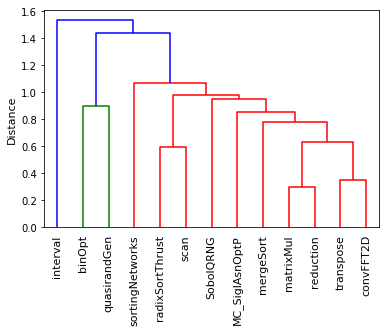

In [61]:
data_array = df_feat10_array

print find_best_method_metric_combination(data_array)


(_, [myMethod, myMetric]) = find_best_method_metric_combination(data_array)

print myMethod, myMetric


pd = pdist(data_array, metric=myMetric)

Z = hierarchy.linkage(data_array, method=myMethod)

# plt.figure(figsize=(25, 10))

# plt.title('Feat10')
plt.ylabel('Distance', fontsize=11)

dn = hierarchy.dendrogram(Z,
                          leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=11,  # font size for the x axis labels
                          labels = app_label
                         )

# plt.savefig('feat10.pdf',  transparent = True, bbox_inches='tight')
# plt.savefig('feat10.png',  dpi=300, transparent = True, bbox_inches='tight')

plt.show()


### dendrogram for feat15

In [62]:
df_feat15_data = df_app_scale_feat15.drop('AppName', axis=1)
df_feat15_array = df_feat15_data.as_matrix()

# dendro = ff.create_dendrogram(df_feat15_array, labels = app_label, 
#                               linkagefun=lambda x: linkage(df_feat15_array, 'ward', metric='euclidean'))

# dendro['layout'].update({'width':800, 'height':500})
# py.iplot(dendro, filename='feat15')

(0.83141944990896155, ['average', 'euclidean'])
average euclidean


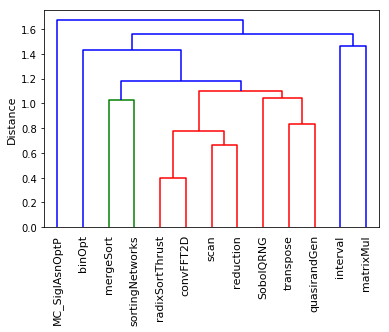

In [63]:
data_array = df_feat15_array

print find_best_method_metric_combination(data_array)


(_, [myMethod, myMetric]) = find_best_method_metric_combination(data_array)

print myMethod, myMetric


pd = pdist(data_array, metric=myMetric)

Z = hierarchy.linkage(data_array, method=myMethod)

plt.ylabel('Distance', fontsize=11)

dn = hierarchy.dendrogram(Z,
                          leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=11,  # font size for the x axis labels
                          labels = app_label
                         )

# plt.savefig('feat15.pdf',  transparent = True, bbox_inches='tight')
# plt.savefig('feat15.png',  dpi=300, transparent = True, bbox_inches='tight')

plt.show()

### dendrogram for feat20

In [64]:
df_feat20_data = df_app_scale_feat20.drop('AppName', axis=1)
df_feat20_array = df_feat20_data.as_matrix()

# dendro = ff.create_dendrogram(df_feat20_array, labels = app_label, 
#                               linkagefun=lambda x: linkage(df_feat20_array, 'ward', metric='euclidean'))

# dendro['layout'].update({'width':800, 'height':500})
# py.iplot(dendro, filename='feat20')

(0.86579077389114867, ['average', 'cosine'])
average cosine


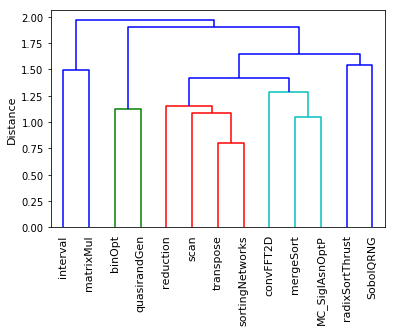

In [65]:
data_array = df_feat20_array

print find_best_method_metric_combination(data_array)


(_, [myMethod, myMetric]) = find_best_method_metric_combination(data_array)

print myMethod, myMetric


pd = pdist(data_array, metric=myMetric)

Z = hierarchy.linkage(data_array, method=myMethod)

plt.ylabel('Distance', fontsize=11)

dn = hierarchy.dendrogram(Z,
                          leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=11,  # font size for the x axis labels
                          labels = app_label
                         )

# plt.savefig('feat20.pdf',  transparent = True, bbox_inches='tight')
# plt.savefig('feat20.png',  dpi=300, transparent = True, bbox_inches='tight')

plt.show()

### dendrogram for feat25

In [66]:
df_feat25_data = df_app_scale_feat25.drop('AppName', axis=1)
df_feat25_array = df_feat25_data.as_matrix()

# dendro = ff.create_dendrogram(df_feat25_array, labels = app_label, 
#                               linkagefun=lambda x: linkage(df_feat25_array, 'ward', metric='euclidean'))

# dendro['layout'].update({'width':800, 'height':500})
# py.iplot(dendro, filename='feat25')

(0.90043700578907115, ['average', 'cosine'])
average cosine


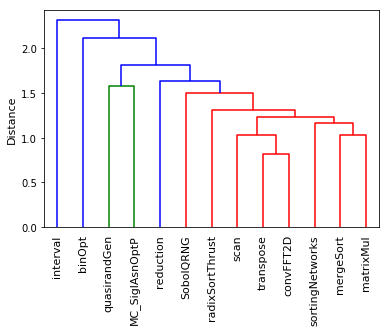

In [67]:
data_array = df_feat25_array

print find_best_method_metric_combination(data_array)


(_, [myMethod, myMetric]) = find_best_method_metric_combination(data_array)

print myMethod, myMetric


pd = pdist(data_array, metric=myMetric)

Z = hierarchy.linkage(data_array, method=myMethod)

plt.ylabel('Distance', fontsize=11)

dn = hierarchy.dendrogram(Z,
                          leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=11,  # font size for the x axis labels
                          labels = app_label
                         )

# plt.savefig('feat25.pdf',  transparent = True, bbox_inches='tight')
# plt.savefig('feat25.png',  dpi=300, transparent = True, bbox_inches='tight')

plt.show()

### dendrogram feat30

In [68]:
df_feat30_data = df_app_scale_feat30.drop('AppName', axis=1)
df_feat30_array = df_feat30_data.as_matrix()

(0.92829675989429272, ['centroid', 'cosine'])
centroid cosine


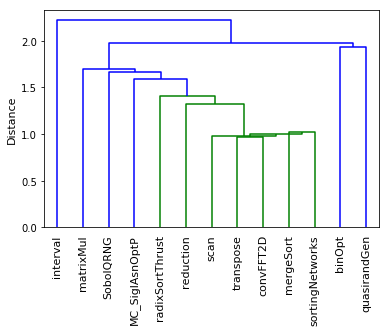

In [70]:
data_array = df_feat30_array

print find_best_method_metric_combination(data_array)


(_, [myMethod, myMetric]) = find_best_method_metric_combination(data_array)

print myMethod, myMetric


pd = pdist(data_array, metric=myMetric)

Z = hierarchy.linkage(data_array, method=myMethod)

plt.ylabel('Distance', fontsize=11)

dn = hierarchy.dendrogram(Z,
                          leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=11,  # font size for the x axis labels
                          labels = app_label
                         )

# plt.savefig('feat30.pdf',  transparent = True, bbox_inches='tight')
# plt.savefig('feat30.png',  dpi=300, transparent = True, bbox_inches='tight')

plt.show()

### dendrogram feat35

In [71]:
df_feat35_data = df_app_scale_feat35.drop('AppName', axis=1)
df_feat35_array = df_feat35_data.as_matrix()

(0.90827570057414586, ['average', 'cosine'])
average cosine


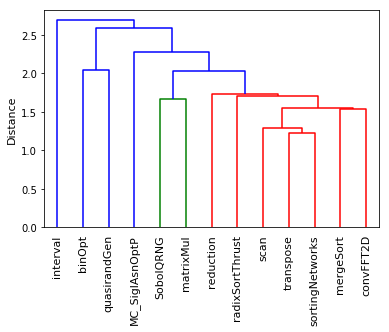

In [72]:
data_array = df_feat35_array

print find_best_method_metric_combination(data_array)


(_, [myMethod, myMetric]) = find_best_method_metric_combination(data_array)

print myMethod, myMetric


pd = pdist(data_array, metric=myMetric)

Z = hierarchy.linkage(data_array, method=myMethod)

plt.ylabel('Distance', fontsize=11)

dn = hierarchy.dendrogram(Z,
                          leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=11,  # font size for the x axis labels
                          labels = app_label
                         )

# plt.savefig('feat35.pdf',  transparent = True, bbox_inches='tight')
# plt.savefig('feat35.png',  dpi=300, transparent = True, bbox_inches='tight')

plt.show()

### dendrogram feat40

In [73]:
df_feat40_data = df_app_scale_feat40.drop('AppName', axis=1)
df_feat40_array = df_feat40_data.as_matrix()

(0.88816380803771078, ['average', 'cosine'])
average cosine


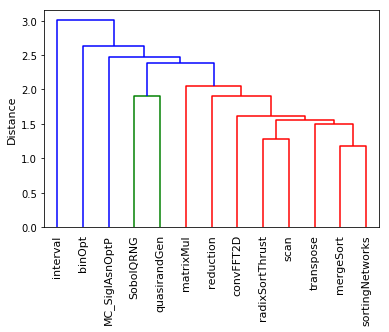

In [74]:
data_array = df_feat40_array

print find_best_method_metric_combination(data_array)


(_, [myMethod, myMetric]) = find_best_method_metric_combination(data_array)

print myMethod, myMetric


pd = pdist(data_array, metric=myMetric)

Z = hierarchy.linkage(data_array, method=myMethod)

plt.ylabel('Distance', fontsize=11)

dn = hierarchy.dendrogram(Z,
                          leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=11,  # font size for the x axis labels
                          labels = app_label
                         )

# plt.savefig('feat40.pdf',  transparent = True, bbox_inches='tight')
# plt.savefig('feat40.png',  dpi=300, transparent = True, bbox_inches='tight')

plt.show()

### dendrogram feat all

In [75]:
app_label

['mergeSort',
 'radixSortThrust',
 'scan',
 'SobolQRNG',
 'transpose',
 'interval',
 'binOpt',
 'matrixMul',
 'quasirandGen',
 'reduction',
 'convFFT2D',
 'MC_SiglAsnOptP',
 'sortingNetworks']

In [76]:
df_app_data  = df_app_scale.drop('AppName', axis=1)
df_app_array = df_app_data.as_matrix()

(0.90740420081313555, ['average', 'cosine'])
average cosine


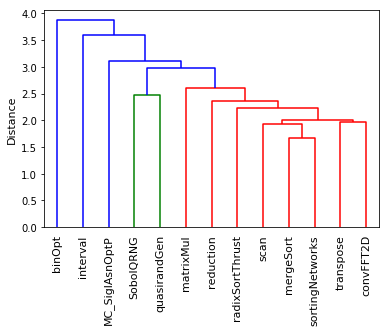

In [82]:
data_array = df_app_array

print find_best_method_metric_combination(data_array)


(_, [myMethod, myMetric]) = find_best_method_metric_combination(data_array)

print myMethod, myMetric


pd = pdist(data_array, metric=myMetric)

Z = hierarchy.linkage(data_array, method=myMethod)

plt.ylabel('Distance', fontsize=11)

dn = hierarchy.dendrogram(Z,
                          leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=11,  # font size for the x axis labels
                          labels = app_label
                         )

# plt.savefig('featAll.pdf',  transparent = True, bbox_inches='tight')
# plt.savefig('featAll.png',  dpi=300, transparent = True, bbox_inches='tight')

plt.show()

In [41]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

# Mystic Metrics

In [40]:
# for column in df_app_scale.columns:
#     print column

In [78]:
feat_mystic = [
'sm_efficiency',
'ipc',
'dram_read_throughput',
'dram_write_throughput',
'dram_read_transactions',   
'dram_write_transactions',
'tex_cache_hit_rate',
'tex_cache_throughput',
'l2_read_throughput',
'l2_write_throughput',
'l2_tex_read_hit_rate',
'l2_tex_read_throughput',
'l2_tex_write_hit_rate',
'l2_tex_write_throughput',
'gld_throughput',
'gld_transactions',
'gst_throughput',
'gst_transactions'
]

print len(feat_mystic)

18


In [79]:
# 
# select features from the scaled data
#
Feat_mystic_with_appname = ['AppName']
Feat_mystic_with_appname.extend(feat_mystic)

df_app_scale_feat_mystic = df_app_scale[Feat_mystic_with_appname]

In [80]:
df_feat_mystic_data = df_app_scale_feat_mystic.drop('AppName', axis=1)
df_feat_mystic_array = df_feat_mystic_data.as_matrix()

(0.78248945892001143, ['average', 'cosine'])
average cosine


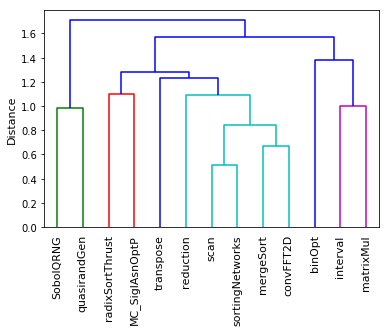

In [81]:
data_array = df_feat_mystic_array

print find_best_method_metric_combination(data_array)


(_, [myMethod, myMetric]) = find_best_method_metric_combination(data_array)

print myMethod, myMetric


pd = pdist(data_array, metric=myMetric)

Z = hierarchy.linkage(data_array, method=myMethod)

plt.ylabel('Distance', fontsize=11)

dn = hierarchy.dendrogram(Z,
                          leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=11,  # font size for the x axis labels
                          labels = app_label
                         )

# plt.savefig('featMystic.pdf',  transparent = True, bbox_inches='tight')
# plt.savefig('featMystic.png',  dpi=300, transparent = True, bbox_inches='tight')

plt.show()

In [45]:
#help(ff.create_dendrogram)